# Practica 5

In [1]:
from deap import creator, tools, base, algorithms
import numpy as np
import random


class Tren:
    def __init__(self, numero_vagones, operacion, matricula):
        self.numero_vagones = numero_vagones
        self.operacion = operacion
        self.matricula = matricula

    def __str__(self):
        return "Número de vagones: " + str(self.numero_vagones) + "\n" + \
        "Muelle de operaciones: " + str(self.operacion) + "\n" + \
                "Matrícula: " + str(self.matricula) + "\n"

    


def producir_lista_trenes_aleatoria(n, min_vagones, max_vagones):
    lista_trenes = []
    for i in range(n):
        numero_vagones = random.randint(min_vagones, max_vagones)
        operacion = random.choice(["gas", "carbón", "contenedores"])
        lista_trenes.append(Tren(numero_vagones, operacion, i))
    return lista_trenes


def crear_cola_de_trenes(lista_de_trenes):
    auxiliar = lista_de_trenes
    random.shuffle(auxiliar)
    return auxiliar


class Cola_de_trenes(list):
    def __init__(self, lista_de_trenes, create = True):
        if create:
            list.extend(self,crear_cola_de_trenes(lista_de_trenes))
        else:
            list.extend(self, lista_de_trenes)

    def __str__(self):
        cadena = ""
        for i in list(self):
            cadena += (str(i) + "\n")
        return cadena

random.seed(2024)

In [2]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create("Individual", Cola_de_trenes, fitness=creator.FitnessMin)

In [3]:
toolbox = base.Toolbox()

# Crear individuos
toolbox.register("individual", creator.Individual, producir_lista_trenes_aleatoria(50, 10, 30))


toolbox.register("individual_mate", creator.Individual)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [4]:
def tiempo_total(indiv):
    sum = 0
    for tren in indiv:
        sum += tren.numero_vagones

    return sum


def evaluar_cola(individuo):
    muelle_gas = 1
    muelle_carbon = 1
    muelle_contenedores = 1
    id_tren = 0
    t_espera = 0

    for i in range(tiempo_total(individuo)):

        if id_tren < len(individuo):
            if (individuo[id_tren].operacion == "gas" and muelle_gas > 0) | (
                    individuo[id_tren].operacion == "carbón" and muelle_carbon > 0) | (
                    individuo[id_tren].operacion == "contenedores" and muelle_contenedores > 0):
                t_espera += 1

        muelle_gas -= 1
        muelle_carbon -= 1
        muelle_contenedores -= 1

        if id_tren >= len(individuo) and muelle_carbon <= 0 and muelle_contenedores <= 0 and muelle_gas <= 0:
            break

        for _ in range(3):

            if id_tren >= len(individuo):
                break

            if individuo[id_tren].operacion == "carbón" and muelle_carbon <= 0:
                muelle_carbon = individuo[id_tren].numero_vagones
                id_tren += 1
                continue
            if individuo[id_tren].operacion == "contenedores" and muelle_contenedores <= 0:
                muelle_contenedores = individuo[id_tren].numero_vagones
                id_tren += 1
                continue

            if individuo[id_tren].operacion == "gas" and muelle_gas <= 0:
                muelle_gas = individuo[id_tren].numero_vagones
                id_tren += 1
                continue

        continue

    return t_espera - 1,


In [5]:
def train_swap(indivuduo, indpb):
    indivuduo = deepcopy(indivuduo)
    if random.random() < indpb:
        pos1 = random.randint(0, len(indivuduo) - 1)
        pos2 = random.randint(0, len(indivuduo) - 1)

        while pos2 == pos1:
            pos2 = random.randint(0, len(indivuduo) - 1)

        train1 = indivuduo[pos1]
        train2 = indivuduo[pos2]
        indivuduo[pos1] = train2
        indivuduo[pos2] = train1

    return indivuduo,

In [6]:
from copy import deepcopy

def trains_mate(indv1, indv2):
    cut = random.randint(0, len(indv1) - 1)
    
    f_half_new_invd1 = indv1[:cut]
    f_half_new_invd2 = indv1[cut:]
    
    l_half_new_invd1 = deepcopy(indv2)
    l_half_new_invd2 = []
    
    for train1 in f_half_new_invd1:
        for train2 in indv2:
            if train1.matricula == train2.matricula:
                for i, t in enumerate(l_half_new_invd1):
                    if train1.matricula == t.matricula:
                        l_half_new_invd1.pop(i)
                        l_half_new_invd2.append(train2)
    
    new_indv1 = f_half_new_invd1 + l_half_new_invd1
    new_indv2 = f_half_new_invd2 + l_half_new_invd2
    
    return toolbox.individual_mate(new_indv1, False), toolbox.individual_mate(new_indv2, False)

(Más adelante se prueban distintas opciones para los hiperparámetros de las siguientes funciones para buscar los mejores individuos. La solución que se muestra a continuación es la que consideramos mejor, la llamaremos Solución 1.)

# Solución 1

In [7]:
toolbox.register("evaluate", evaluar_cola)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", trains_mate)
toolbox.register("mutate", train_swap, indpb=0.03)

In [8]:
ranking = tools.HallOfFame(5)
estadisticas = tools.Statistics(lambda indiv: indiv.fitness.values)
estadisticas.register("promedio", np.mean)
estadisticas.register("max", np.max)
estadisticas.register("min", np.min)

In [9]:
poblacion = toolbox.population(n=500)
pop, logbook = algorithms.eaSimple(poblacion, toolbox, cxpb=0.5, mutpb=0.2, ngen=75, stats=estadisticas, halloffame=ranking, verbose=True)

gen	nevals	promedio	max	min
0  	500   	524.852 	629	433
1  	315   	494.93  	570	431
2  	295   	474.444 	547	414
3  	298   	458.784 	562	409
4  	308   	446.99  	523	407
5  	295   	437.312 	546	400
6  	298   	428.944 	520	385
7  	286   	422.11  	502	374
8  	318   	417.66  	489	372
9  	291   	413.176 	502	374
10 	311   	405.686 	484	368
11 	313   	398.322 	486	368
12 	312   	391.038 	498	361
13 	292   	385.032 	454	361
14 	276   	381.042 	442	361
15 	303   	379.324 	437	357
16 	307   	377.64  	432	357
17 	309   	375.598 	440	352
18 	313   	372.092 	447	352
19 	284   	369.118 	429	352
20 	304   	365.356 	421	350
21 	287   	363.604 	413	350
22 	297   	363.152 	417	350
23 	290   	361.748 	399	350
24 	291   	359.366 	388	350
25 	309   	359.274 	392	350
26 	284   	357.638 	383	350
27 	292   	357.28  	393	350
28 	299   	356.582 	415	350
29 	279   	355.85  	387	350
30 	312   	356.14  	393	350
31 	284   	354.588 	390	350
32 	283   	354.386 	403	350
33 	313   	355.174 	397	350
34 	278   	354.592 	

In [10]:
print(f'El mejor individuo es \n {ranking[0]} con aptitud {ranking[0].fitness}')

El mejor individuo es 
 Número de vagones: 23
Muelle de operaciones: contenedores
Matrícula: 31

Número de vagones: 21
Muelle de operaciones: carbón
Matrícula: 37

Número de vagones: 17
Muelle de operaciones: gas
Matrícula: 49

Número de vagones: 21
Muelle de operaciones: contenedores
Matrícula: 17

Número de vagones: 20
Muelle de operaciones: carbón
Matrícula: 41

Número de vagones: 21
Muelle de operaciones: gas
Matrícula: 22

Número de vagones: 19
Muelle de operaciones: contenedores
Matrícula: 9

Número de vagones: 29
Muelle de operaciones: gas
Matrícula: 8

Número de vagones: 20
Muelle de operaciones: carbón
Matrícula: 23

Número de vagones: 20
Muelle de operaciones: contenedores
Matrícula: 10

Número de vagones: 16
Muelle de operaciones: gas
Matrícula: 27

Número de vagones: 24
Muelle de operaciones: contenedores
Matrícula: 13

Número de vagones: 12
Muelle de operaciones: gas
Matrícula: 45

Número de vagones: 28
Muelle de operaciones: carbón
Matrícula: 1

Número de vagones: 23
Muel

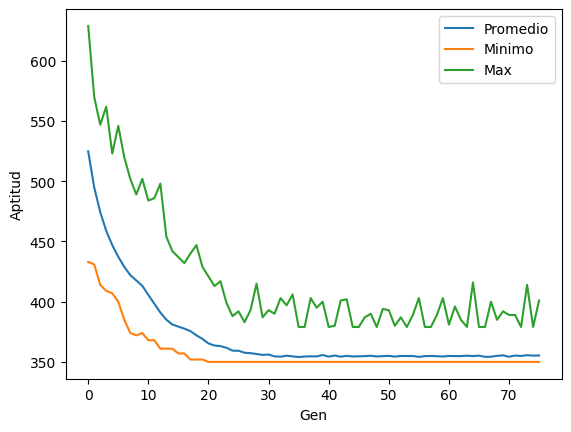

In [11]:
import matplotlib.pyplot as plt

gen, prom, min, max = logbook.select("gen", "promedio", "min", "max")

plt.plot(gen, prom, label="Promedio")
plt.plot(gen, min, label="Minimo")
plt.plot(gen, max, label="Max")
plt.xlabel("Gen")
plt.ylabel("Aptitud")
plt.legend(loc="upper right")
plt.show()

# Cambios en los hiperparámetros

En las siguientes celdas de código se prueban distintas configuraciones de los hiperparámetros para buscar otras opciones.



**Configuración 1**

*Cambios respecto a la solución 1*

-Número de generaciones: Antes 75 / Ahora 40
-Probabilidad de cruce: Antes 0.5 / Ahora 0.7
-Tamaño de la población: Antes 500 / Ahora 100

In [12]:
toolbox.register("evaluate", evaluar_cola)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", trains_mate)
toolbox.register("mutate", train_swap, indpb=0.03)

ranking = tools.HallOfFame(5)
estadisticas = tools.Statistics(lambda indiv: indiv.fitness.values)
estadisticas.register("promedio", np.mean)
estadisticas.register("max", np.max)
estadisticas.register("min", np.min)

poblacion = toolbox.population(n=100)
pop, logbook = algorithms.eaSimple(poblacion, toolbox, cxpb=0.7, mutpb=0.2, ngen=40, stats=estadisticas, halloffame=ranking, verbose=True)

gen	nevals	promedio	max	min
0  	100   	529.87  	624	435
1  	78    	496.08  	558	427
2  	83    	476.44  	530	415
3  	83    	463.73  	552	415
4  	69    	452.17  	507	415
5  	75    	437.2   	494	406
6  	68    	428.06  	512	404
7  	78    	425.57  	490	404
8  	78    	422.26  	481	393
9  	69    	419.78  	471	393
10 	72    	414.06  	473	382
11 	81    	410.64  	460	382
12 	82    	408.41  	450	382
13 	73    	399.2   	451	378
14 	74    	395.03  	430	378
15 	80    	393.22  	427	378
16 	76    	389.89  	422	374
17 	88    	385.34  	401	366
18 	76    	385.06  	417	365
19 	86    	383.57  	416	359
20 	82    	380.33  	405	359
21 	82    	378.35  	411	359
22 	79    	377.79  	417	359
23 	83    	373.83  	403	357
24 	77    	371.89  	396	357
25 	75    	369.99  	397	354
26 	68    	369.35  	389	354
27 	76    	369.77  	391	354
28 	79    	368.5   	404	354
29 	72    	365.81  	393	354
30 	79    	364.7   	402	350
31 	68    	361.99  	387	350
32 	83    	362.37  	396	350
33 	91    	363.27  	387	350
34 	70    	360.54  	

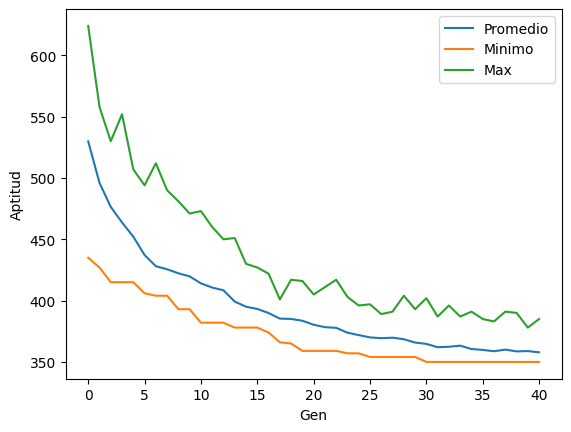

In [13]:
import matplotlib.pyplot as plt

gen, prom, min, max = logbook.select("gen", "promedio", "min", "max")

plt.plot(gen, prom, label="Promedio")
plt.plot(gen, min, label="Minimo")
plt.plot(gen, max, label="Max")
plt.xlabel("Gen")
plt.ylabel("Aptitud")
plt.legend(loc="upper right")
plt.show()

**Conclusion**

Con esta configuración el algoritmo es más rápida, pero no haya la solución óptima (t = 350). Y los máximos de las generaciones parecen no tener tantos picos como la solución 1.

**Configuración 2**

*Cambios respecto a la solución 1*

-Número de generaciones: Antes 75 / Ahora 40
-Probabilidad de mutación: Antes 0.03 / Ahora 0.2
-Probabilidad de mutación de un individuo: Antes 0.2 / Ahora 0.5
-Probabilidad de cruce: Antes 0.5 / Ahora 0.2
-Tamaño de la población: Antes 500 / Ahora 50

In [14]:
toolbox.register("evaluate", evaluar_cola)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", trains_mate)
toolbox.register("mutate", train_swap, indpb=0.2)

ranking = tools.HallOfFame(5)
estadisticas = tools.Statistics(lambda indiv: indiv.fitness.values)
estadisticas.register("promedio", np.mean)
estadisticas.register("max", np.max)
estadisticas.register("min", np.min)

poblacion = toolbox.population(n=50)
pop, logbook = algorithms.eaSimple(poblacion, toolbox, cxpb=0.2, mutpb=0.5, ngen=40, stats=estadisticas, halloffame=ranking, verbose=True)

gen	nevals	promedio	max	min
0  	50    	523.46  	669	448
1  	30    	495.6   	561	460
2  	30    	478.18  	513	444
3  	33    	466.94  	504	432
4  	27    	461.92  	487	432
5  	26    	452.86  	467	432
6  	28    	446.46  	490	432
7  	29    	440.06  	484	399
8  	23    	431.7   	444	399
9  	32    	431.06  	453	399
10 	32    	427.22  	477	399
11 	31    	418.24  	441	398
12 	30    	411.38  	452	398
13 	29    	406.02  	451	398
14 	35    	401.38  	443	382
15 	33    	401.58  	448	382
16 	35    	398.74  	424	382
17 	31    	396.48  	432	382
18 	29    	394.82  	426	382
19 	25    	387.62  	410	382
20 	32    	384.32  	407	361
21 	24    	384.74  	428	361
22 	39    	382.76  	408	361
23 	27    	379.86  	407	361
24 	30    	374.88  	399	361
25 	29    	367.7   	400	361
26 	33    	364.54  	389	360
27 	28    	363.66  	386	360
28 	36    	366.68  	401	360
29 	22    	364.4   	402	360
30 	37    	363.66  	394	360
31 	29    	362.82  	401	360
32 	22    	361     	406	360
33 	34    	362.52  	389	360
34 	30    	364.94  	

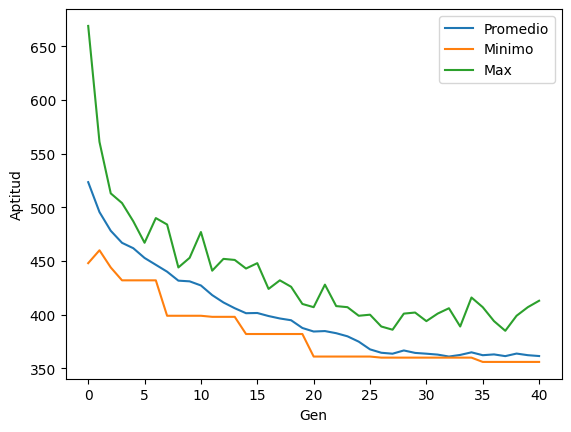

In [15]:
import matplotlib.pyplot as plt

gen, prom, min, max = logbook.select("gen", "promedio", "min", "max")

plt.plot(gen, prom, label="Promedio")
plt.plot(gen, min, label="Minimo")
plt.plot(gen, max, label="Max")
plt.xlabel("Gen")
plt.ylabel("Aptitud")
plt.legend(loc="upper right")
plt.show()

**Conclusion**

Esta configuración es muchísimo más rápida, pero no haya la solución óptima del problema, aunque da una solución decente.

**Configuración 3**

*Cambios respecto a la solución 1*

-Número de generaciones: Antes 75 / Ahora 5
-Probabilidad de cruce: Antes 0.5 / Ahora 1.0
-Tamaño de la población: Antes 500 / Ahora 10000
-Tamaño del Torneo: Antes 3 / Ahora 5

In [16]:
toolbox.register("evaluate", evaluar_cola)
toolbox.register("select", tools.selTournament, tournsize=5)
toolbox.register("mate", trains_mate)
toolbox.register("mutate", train_swap, indpb=0.03)

ranking = tools.HallOfFame(5)
estadisticas = tools.Statistics(lambda indiv: indiv.fitness.values)
estadisticas.register("promedio", np.mean)
estadisticas.register("max", np.max)
estadisticas.register("min", np.min)

poblacion = toolbox.population(n=10000)
pop, logbook = algorithms.eaSimple(poblacion, toolbox, cxpb=1.0, mutpb=0.2, ngen=5, stats=estadisticas, halloffame=ranking, verbose=True)

gen	nevals	promedio	max	min
0  	10000 	526.106 	685	397
1  	10000 	486.086 	625	392
2  	10000 	462.618 	582	387
3  	10000 	446.579 	546	380
4  	10000 	434.299 	560	369
5  	10000 	424.879 	541	366


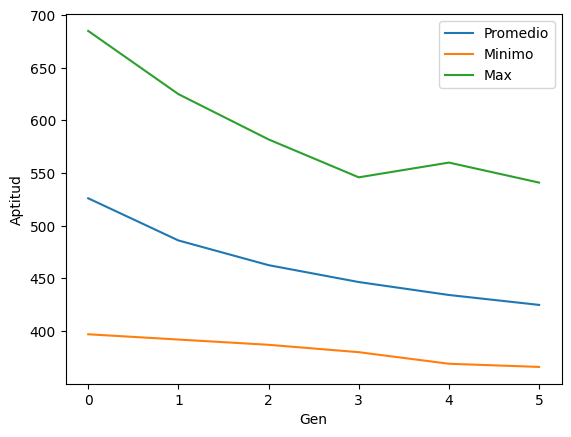

In [17]:
import matplotlib.pyplot as plt

gen, prom, min, max = logbook.select("gen", "promedio", "min", "max")

plt.plot(gen, prom, label="Promedio")
plt.plot(gen, min, label="Minimo")
plt.plot(gen, max, label="Max")
plt.xlabel("Gen")
plt.ylabel("Aptitud")
plt.legend(loc="upper right")
plt.show()

**Conclusion**

El promedio, el máximo y el mínimo están bastante alejados. Cada generación tarda mucho en procesarse porque son 10000 individuos. No da con la mejor solución, pero sí una buena opción.

**Configuración 4**

*Cambios respecto a la solución 1*

-Número de generaciones: Antes 75 / Ahora 200
-Probabilidad de cruce: Antes 0.5 / Ahora 0.3
-Probabilidad de mutación de un individuo: Antes 0.2 / Ahora 0.5
-Tamaño de la población: Antes 500 / Ahora 10
-Tamaño Hall of Fame: Antes 5 / Ahora 10

In [18]:
toolbox.register("evaluate", evaluar_cola)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", trains_mate)
toolbox.register("mutate", train_swap, indpb=0.03)

ranking = tools.HallOfFame(10)
estadisticas = tools.Statistics(lambda indiv: indiv.fitness.values)
estadisticas.register("promedio", np.mean)
estadisticas.register("max", np.max)
estadisticas.register("min", np.min)

poblacion = toolbox.population(n=10)
pop, logbook = algorithms.eaSimple(poblacion, toolbox, cxpb=0.3, mutpb=0.5, ngen=200, stats=estadisticas, halloffame=ranking, verbose=True)

gen	nevals	promedio	max	min
0  	10    	524.1   	563	466
1  	7     	505.3   	550	466
2  	6     	477.8   	507	466
3  	8     	471.8   	488	464
4  	5     	465.5   	466	464
5  	9     	464     	466	459
6  	7     	462     	464	459
7  	8     	463     	482	457
8  	5     	461.1   	482	457
9  	7     	460.9   	482	457
10 	7     	459.2   	466	457
11 	8     	458     	467	457
12 	7     	457.3   	460	457
13 	5     	460.3   	482	457
14 	7     	457.5   	460	457
15 	3     	456.8   	465	447
16 	7     	454     	477	447
17 	7     	450.7   	465	447
18 	6     	447     	447	447
19 	9     	449     	463	447
20 	5     	447     	447	447
21 	8     	448.8   	456	447
22 	8     	446.8   	447	445
23 	6     	446.4   	447	445
24 	7     	447.9   	465	445
25 	8     	445.4   	456	438
26 	9     	446.8   	458	438
27 	6     	441.9   	445	438
28 	5     	438.3   	444	429
29 	5     	437.1   	438	429
30 	5     	437.7   	453	426
31 	8     	432     	452	426
32 	8     	430.1   	453	426
33 	5     	426.3   	428	426
34 	3     	427     	

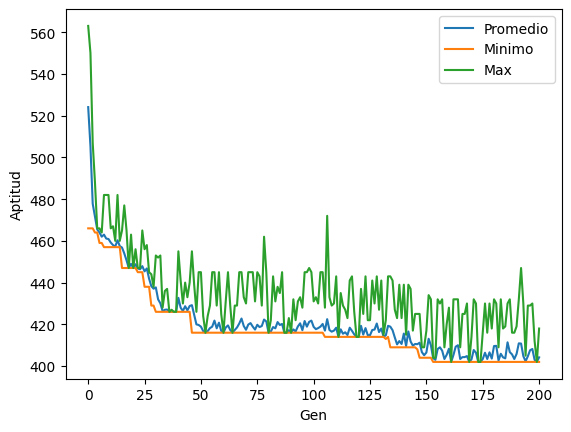

In [19]:
import matplotlib.pyplot as plt

gen, prom, min, max = logbook.select("gen", "promedio", "min", "max")

plt.plot(gen, prom, label="Promedio")
plt.plot(gen, min, label="Minimo")
plt.plot(gen, max, label="Max")
plt.xlabel("Gen")
plt.ylabel("Aptitud")
plt.legend(loc="upper right")
plt.show()

**Conclusion**

Es muy rápido, es la solución que da la peor solución hasta ahora y los máximos en las generaciones tienen muchos picos mientras que los mínimos bajan gradualmente.

**Configuración 5**

*Cambios respecto a la solución 1*

-Número de generaciones: Antes 75 / Ahora 30
-Probabilidad de cruce: Antes 0.5 / Ahora 0.8
-Probabilidad de mutación: Antes 0.03 / Ahora 0.5
-Probabilidad de mutación de un individuo: Antes 0.2 / Ahora 0.8
-Tamaño de la población: Antes 500 / Ahora 25
-Tamaño del Torneo: Antes 3 / Ahora 10

In [20]:
toolbox.register("evaluate", evaluar_cola)
toolbox.register("select", tools.selTournament, tournsize=10)
toolbox.register("mate", trains_mate)
toolbox.register("mutate", train_swap, indpb=0.5)

ranking = tools.HallOfFame(5)
estadisticas = tools.Statistics(lambda indiv: indiv.fitness.values)
estadisticas.register("promedio", np.mean)
estadisticas.register("max", np.max)
estadisticas.register("min", np.min)

poblacion = toolbox.population(n=25)
pop, logbook = algorithms.eaSimple(poblacion, toolbox, cxpb=0.8, mutpb=0.8, ngen=30, stats=estadisticas, halloffame=ranking, verbose=True)

gen	nevals	promedio	max	min
0  	25    	524.08  	591	458
1  	23    	484.44  	540	455
2  	21    	461.28  	529	440
3  	24    	454.08  	495	410
4  	24    	438.64  	471	401
5  	24    	422.28  	493	393
6  	25    	411.92  	444	393
7  	25    	404.24  	427	388
8  	23    	399.56  	425	369
9  	25    	395.04  	459	369
10 	24    	383.36  	429	362
11 	24    	375.08  	415	361
12 	23    	375     	411	361
13 	23    	372     	409	358
14 	22    	369.32  	412	355
15 	25    	372.4   	413	355
16 	23    	371.24  	408	352
17 	25    	366.04  	397	352
18 	23    	363.04  	405	352
19 	24    	365.36  	409	352
20 	24    	365.88  	394	351
21 	23    	362.6   	398	351
22 	24    	370.56  	413	351
23 	23    	363.16  	396	351
24 	24    	361.16  	398	351
25 	22    	362.2   	382	351
26 	25    	364.44  	409	351
27 	25    	362.04  	404	351
28 	22    	362.04  	395	351
29 	22    	364.92  	400	351
30 	25    	368.04  	402	351


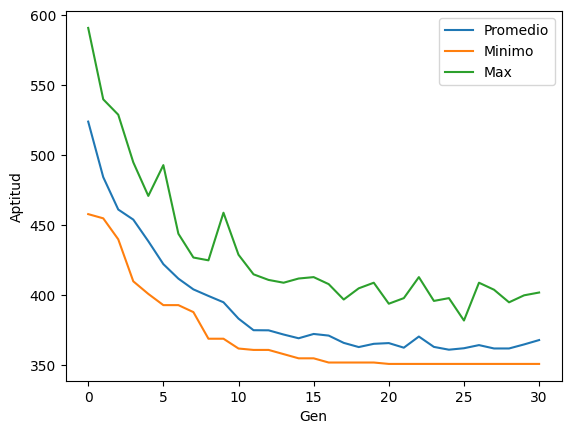

In [21]:
import matplotlib.pyplot as plt

gen, prom, min, max = logbook.select("gen", "promedio", "min", "max")

plt.plot(gen, prom, label="Promedio")
plt.plot(gen, min, label="Minimo")
plt.plot(gen, max, label="Max")
plt.xlabel("Gen")
plt.ylabel("Aptitud")
plt.legend(loc="upper right")
plt.show()

**Conclusion**

No llega a la solución óptima pero llega a una bastante buena. Es muy rápido y los máximos tienen algunos repuntes. A pesar de no dar que el individuo óptimo, quizás es la mejor configuración calidad-tiempo.